# Computer Vision and Pattern Recognition - Project 3 (CNN classifier)
#### Gaia Marsich [SM3500600]

* [Introduction](#intro)
* [1. Task 1](#1-bullet)
    * [1.1. Data augmentation](#data-aug)
* [2. Task 2](#2-bullet)
* [3. Task 3](#3-bullet)
* [References](#ref)

## Introduction <a class="anchor" id="intro"></a>

This project requires the implementation of an image classifier based on convolutional neural networks. The provided dataset (from [Lazebnik et al., 2006]), contains 15 categories (office, kitchen, living room, bedroom, store, industrial, tall building, inside city, street, highway, coast, open country, mountain, forest, suburb), and is already divided in training set and test set.

First of all, let's do the imports:

In [1]:
import torch
from torch import nn

import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import ImageOps

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from torch.utils.data import Dataset

## Task 1 <a class="anchor" id="1-bullet"></a>

In [2]:
# set a seed for reproducibility
torch.manual_seed(1)

# Build the network

class CNN(nn.Module):

    # A model will have an __init__() function, where it instantiates its layers

    def __init__(self):
        super(CNN, self).__init__() # the constructor of the parent class (nn.Module) is called to initialize the model properly.

        # Convolutional layer 1: in_channels=1 because we have a greyscale
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1) # from [1] we get the formula: output = ((input - kernel_size + 2*padding)/stride) + 1 => 62*62
        # ReLU activation after conv1
        self.relu1 = nn.ReLU() # output: 62*62
        # Max pooling layer 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 31*31 (from 62/2)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1) # from [1] we know that output: 29*29
        # ReLU activation after conv2
        self.relu2 = nn.ReLU() # output: 29*29
        # Max pooling layer 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 14*14 (from the test in dim_images.ipynb)

        # Convolutional layer 3
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1) # from [1] we know that output: 12*12
        # ReLU activation after conv3  
        self.relu3 = nn.ReLU() # output: 12*12

        # Fully connected layer. 32: number of channels; 12, 12: height and width of the feature map
        self.fc = nn.Linear(32 * 12 * 12, 15)
        # Classification layer
        #self.output = nn.CrossEntropyLoss() #TODO: ma è giusto da mettere? Al momento è tolto

        self.initialize_weights()




    def initialize_weights(self):       #TODO: the professor mentioned to avoid normalization, what should I do?
        for module in self.modules(): # self.modules() comes from nn.Module; to recursively iterate over all the modules
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                init.normal_(module.weight, mean=0, std=0.01) # initial weights drawn from a Gaussian distribution having a mean of 0 and a standard deviation of 0.01
                init.constant_(module.bias, 0) # set the bias to 0




    # A model will have a forward() function
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = x.view(-1, 32 * 12 * 12)  # flatten the tensor before passing to fully connected layers (the size -1 is inferred from other dimensions)
        
        x = self.fc(x)
        #x = self.output(x) #TODO: in caso, da eliminare

        return x

In [3]:
# Load the dataset

train_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/train'
test_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/test'

def transform(image):
    resize = transforms.Compose([transforms.Resize([64,64]), # resize the images as 64x64
                                 transforms.ToTensor(), # to get a PyTorch tensor. The pixels' values will be scaled from the range [0, 255] to the range [0.0, 1.0]
                                 transforms.Grayscale()]) # the image will just have one channel
    resized_image = resize(image)
    resized_image = resized_image * 255.0 # revert the normalization, i.e., go back to range [0, 255]
    return resized_image

train = ImageFolder(root=train_path, transform=transform)
dataset_test = ImageFolder(root=test_path, transform=transform)


# Split the provided training set in 85% for training set and 15% for validation set

train_size = int(0.85 * len(train))
val_size = len(train) - train_size

dataset_train, dataset_val = random_split(train, [train_size, val_size])


# Create the loaders

batch_size = 32 # batch_size = 32 as required by the project
train_loader = DataLoader(dataset_train, batch_size, shuffle=True) 
val_loader = DataLoader(dataset_val, batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size, shuffle=False)

Let's instantiate a model...

In [4]:
# Instantiate a model

model = CNN()

# Set parameters for the training

learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate) # the momentum by default is 0, but I need it different from 0

...and do the training:

In [5]:
# Method to train for just one epoch

def train_one_epoch(epoch_index, model, loader, optimizer, loss_function): # to train for just one epoch (one epoch: the network sees the whole training set)
    running_loss = 0.

    for i, data in enumerate(loader):

        inputs, labels = data # get the minibatch

        outputs = model(inputs) # forward pass

        loss = loss_function(outputs, labels) # compute the loss
        running_loss += loss.item() # sum up the loss for the minibatches processed so far

        optimizer.zero_grad() # notice that by default, the gradients are accumulated, hence we need to set them to zero
        loss.backward() # backward pass
        optimizer.step() # update the weights

    return running_loss/(i+1) # average loss per minibatch




# Method to do the training

def train_model(model, EPOCHS, train_loader, val_loader, optimizer, loss_function):

    best_validation_loss = np.inf

    loss_train = [] # store the values of the loss for the training set
    loss_val = [] # store the values of the loss for the validation set
    accuracies_val = [] # store the values of the accuracy for the validation set

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        train_loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_function)
        loss_train.append(train_loss)

        running_validation_loss = 0.0

        # If using dropout and/or batch normalization, we need the following, to set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()


        correct = 0
        total = 0

        with torch.no_grad():      # disable gradient computation and reduce memory consumption
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_function(voutputs, vlabels)
                running_validation_loss += vloss
                _, predicted = torch.max(voutputs.data, 1)
                total += vlabels.size(0)
                correct += (predicted == vlabels).sum().item()
        
        accuracy = 100 * correct / total
        accuracies_val.append(accuracy)

        validation_loss = running_validation_loss / (i + 1) # average validation loss per minibatch
        loss_val.append(validation_loss)
        
        print('LOSS: train: {}, validation: {}; accuracy validation set: {}%\n'.format(train_loss, validation_loss, accuracy))


        # Track best performance (based on validation), and save the model
        if validation_loss < best_validation_loss:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            best_validation_loss = validation_loss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

    return model_path, loss_train, loss_val, accuracies_val



# Perform the training
model_path, loss_train, loss_val, accuracies_val = train_model(model = model, EPOCHS = 40, train_loader = train_loader, val_loader = val_loader, optimizer = optimizer, loss_function = loss_function)



EPOCH 1:
LOSS: train: 2.7081405580043794, validation: 2.7080423831939697; accuracy validation set: 10.666666666666666%

EPOCH 2:
LOSS: train: 2.7079244017601014, validation: 2.7083287239074707; accuracy validation set: 7.555555555555555%

EPOCH 3:
LOSS: train: 2.7077725172042846, validation: 2.7083029747009277; accuracy validation set: 7.555555555555555%

EPOCH 4:
LOSS: train: 2.7076546967029573, validation: 2.7086310386657715; accuracy validation set: 4.0%

EPOCH 5:
LOSS: train: 2.7074990570545197, validation: 2.7086615562438965; accuracy validation set: 5.333333333333333%

EPOCH 6:
LOSS: train: 2.7072977662086486, validation: 2.708981990814209; accuracy validation set: 4.888888888888889%

EPOCH 7:
LOSS: train: 2.7069836139678953, validation: 2.7093095779418945; accuracy validation set: 4.888888888888889%

EPOCH 8:
LOSS: train: 2.7064767599105837, validation: 2.710216522216797; accuracy validation set: 5.777777777777778%

EPOCH 9:
LOSS: train: 2.7056257724761963, validation: 2.7122945

Here, the training is performed with the support of a validation set so that, during the training, the generalisation capability of the current network can be estimated. The analysis keeps going until the number of epochs that has been set is reached.
However, the algorithm compares the model at the current epoch with the best model previously obtained, where the performances are based on the validation loss. At the end, the more recent model will be the optimal one among those that had been tested.

Let's have a look at the plot of the loss during the training:

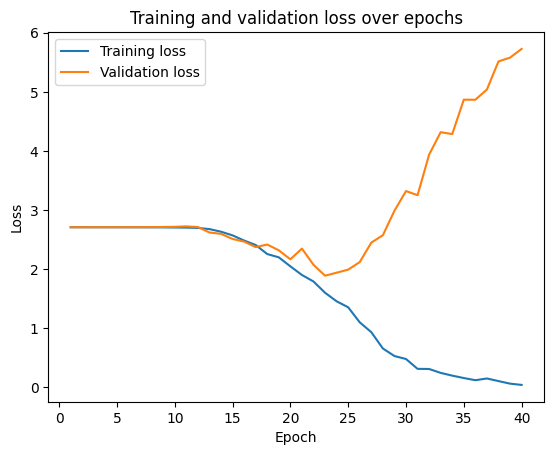

In [6]:
epochs = list(range(1, len(loss_train) + 1)) # epochs started from 0

plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='Validation loss')
plt.title('Training and validation loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


As expected, since the network is trained on a specific train set over and over, the loss associated to this set keeps decreasing. On the other hand, the tests done on a separate set, the validation set, report an increase of the loss.

Here it is the plot on the validation accuracy:

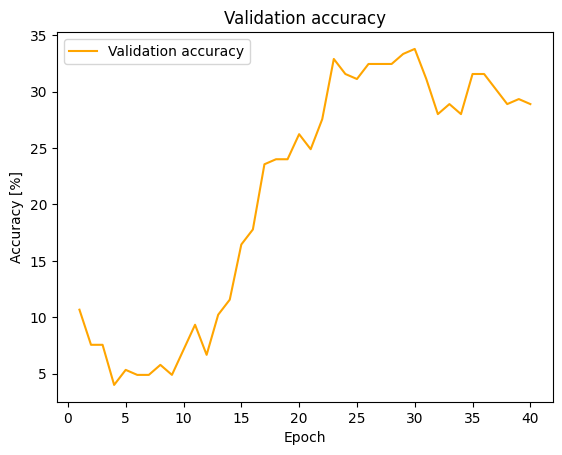

In [7]:
plt.plot(epochs, accuracies_val, color='orange', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.legend()
plt.show()

The more the network is trained the more it is expected to perform correctly. In this graph, one can observe that the accuracy associated to the validation set increases; however, it shows an oscillating trend.

Let's evaluate the accuracy on the test set:

Accuracy of the network on the test images: 30 %


<Axes: >

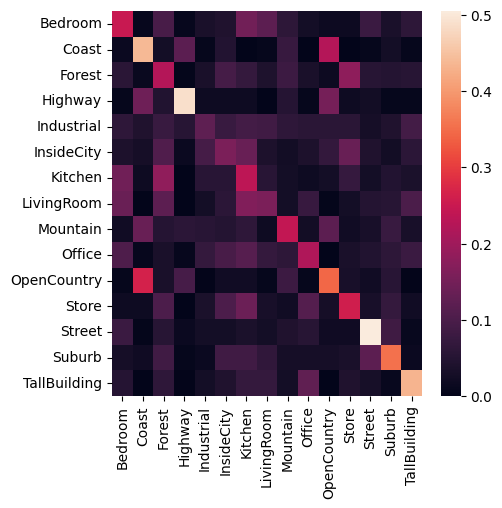

In [8]:
# Evaluate the trained network on the test set, and collect the infos for the confusion matrix

correct_test = 0
total_test = 0

y_pred = []
y_true = []

with torch.no_grad():

    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_true.extend(labels) 


accuracy_test = 100 * correct_test / total_test
print('Accuracy of the network on the test images: %d %%' % (accuracy_test))

# Build confusion matrix
classes = dataset_test.classes
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=False)
#plt.savefig('output.png')

## Task 2 <a class="anchor" id="2-bullet"></a>

The previous result can be improved using some techniques, that will be applied one after the other cumulatively.

### Data augmentation <a class="anchor" id="data-aug"></a>

The only difference with the original version is the train/validation dataset: "new" images are added to the initial training and validation dataset. The "new" images are simply the left-to-right reflections of the original train/validation dataset.

In [12]:
torch.manual_seed(3)

# Load the dataset

train_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/train'
test_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/test'

train = ImageFolder(root=train_path, transform=transform)
dataset_test = ImageFolder(root=test_path, transform=transform)


# Split the provided training set in 85% for training set and 15% for validation set

train_size = int(0.85 * len(train))
val_size = len(train) - train_size

dataset_train, dataset_val = random_split(train, [train_size, val_size])


# Data augmentation for the train dataset

class HorizontallyFlippedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.horizontal_flip_transform = transforms.RandomHorizontalFlip()

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        flipped_image = self.horizontal_flip_transform(image)
        return flipped_image, label

    def __len__(self):
        return len(self.original_dataset)



flipped_dataset_train = HorizontallyFlippedDataset(dataset_train)
data_augmentation_dataset_train = torch.utils.data.ConcatDataset([dataset_train, flipped_dataset_train])


# Create the loaders

batch_size = 32
data_augmentation_train_loader = DataLoader(data_augmentation_dataset_train, batch_size, shuffle=True) 
val_loader = DataLoader(dataset_val, batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size, shuffle=False)

Now let's instantiate the model and perform the training:

In [13]:
# Instantiate a model

model_data_augmentation = CNN()


# Set parameters for the training

learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_data_augmentation.parameters(), momentum=0.9, lr=learning_rate) # the momentum by default is 0, but I need it different from 0

# Perform the training
model_path, data_augmentation_loss_train, data_augmentation_loss_val, data_augmentation_accuracies_val = train_model(model = model_data_augmentation, EPOCHS = 40, train_loader = data_augmentation_train_loader, val_loader = val_loader, optimizer = optimizer, loss_function = loss_function)

EPOCH 1:
LOSS: train: 2.707371953129768, validation: 2.7098236083984375; accuracy validation set: 5.777777777777778%

EPOCH 2:
LOSS: train: 2.701735556125641, validation: 2.719569683074951; accuracy validation set: 5.777777777777778%

EPOCH 3:
LOSS: train: 2.6715938568115236, validation: 2.6666066646575928; accuracy validation set: 9.333333333333334%

EPOCH 4:
LOSS: train: 2.5955696046352386, validation: 2.6293821334838867; accuracy validation set: 17.77777777777778%

EPOCH 5:
LOSS: train: 2.509810966253281, validation: 2.5342445373535156; accuracy validation set: 16.444444444444443%

EPOCH 6:
LOSS: train: 2.4723249971866608, validation: 2.5910253524780273; accuracy validation set: 17.333333333333332%

EPOCH 7:
LOSS: train: 2.4069895058870316, validation: 2.564208745956421; accuracy validation set: 20.444444444444443%

EPOCH 8:
LOSS: train: 2.209269958734512, validation: 2.5260164737701416; accuracy validation set: 21.77777777777778%

EPOCH 9:
LOSS: train: 2.239325587451458, validation

In [14]:
# Evaluate the trained network on the test set

correct_test = 0
total_test = 0

y_pred = []
y_true = []

with torch.no_grad():
    model_data_augmentation.load_state_dict(torch.load(model_path))
    model.eval()
    
    for data in test_loader:
        images, labels = data
        outputs = model_data_augmentation(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_true.extend(labels) 


accuracy_test = 100 * correct_test / total_test
print('Accuracy of the network on the test images: %d %%' % (accuracy_test))

Accuracy of the network on the test images: 27 %


## Task 3 <a class="anchor" id="3-bullet"></a>

## References <a class="anchor" id="ref"></a>

[1] https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6